# Monte Carlo & Adjoint-Mode Greeks  
**Jackson Pfaff – May 2025**

---
# 1. Monte Carlo Setup (One-Step GBM)

We simulate $N$ correlated assets over the interval $[0,T]$ in a single log-Euler step:

1. **Correlation and normal draws**  
   Let $\Sigma \in \mathbb{R}^{N \times N}$ be the assets’ correlation matrix.  
   Compute its lower-triangular Cholesky factor $L$ so that $LL^\top = \Sigma$.  
   Draw:

   $$
   Z \sim \mathcal{N}(\mathbf{0}, I_N), \quad Y = LZ \quad (\text{then } \mathrm{Cov}[Y] = \Sigma)
   $$

2. **Log-price increment**  
   For each asset $i = 1, \dots, N$, compute:

   $$
   \text{drift}_i = \left( r - \tfrac{1}{2} \sigma_i^2 \right) T, \quad
   \text{diffusion}_i = \sigma_i \sqrt{T} Y_i
   $$

3. **Terminal price**  
   Define the log-argument:

   $$
   G_i = \ln S_{0,i} + \text{drift}_i + \text{diffusion}_i
   $$

   Then:

   $$
   S_i(T) = e^{G_i}
   $$

4. **Worst-of payoff**  
   $$
   S^* = \min_{1 \le i \le N} S_i(T), \quad
   A = S^* - K, \quad
   h = \max(A, 0), \quad
   D = e^{-rT}, \quad
   P = D h
   $$

5. **Monte Carlo estimator**  
   Over $M$ independent paths:

   $$
   \widehat{V} = \frac{1}{M} \sum_{m=1}^M P^{(m)} =
   \frac{e^{-rT}}{M} \sum_{m=1}^M \left( \min_i S_i^{(m)}(T) - K \right)^+
   $$

---

# 2. Adjoint-Mode Delta

We wish to compute the pathwise sensitivity $\Delta_i = \partial P / \partial S_{0,i}$ via reverse-mode (adjoint) differentiation.

1. **Initialize**  
   $\bar{P} = 1$

2. **Back through discount**  
   $P = D h$ gives:

   $$
   \bar{h} = D \bar{P}
   $$

3. **Back through ReLU payoff**  
   $h = \max(A, 0)$ gives:

   $$
   \bar{A} = \mathbb{1}_{\{A > 0\}} \bar{h}
   $$

4. **Back through subtraction**  
   $A = S^* - K$ gives:

   $$
   \bar{S}^* = \bar{A}
   $$

5. **Back through minimum**  
   $S^* = \min_i S_i(T)$ gives, for each $i$:

   $$
   \bar{S}_i(T) = \mathbb{1}_{\{i = i^*\}} \bar{S}^*, \quad
   i^* = \operatorname*{arg\,min}_i S_i(T)
   $$

6. **Back through exponential**  
   $S_i(T) = e^{G_i}$ gives:

   $$
   \bar{G}_i = S_i(T) \bar{S}_i(T)
   $$

7. **Back through log-Euler step**  
   $G_i = \ln S_{0,i} + (r - \tfrac{1}{2} \sigma_i^2)T + \sigma_i \sqrt{T} Y_i$ gives:

   $$
   \bar{S}_{0,i} = \frac{1}{S_{0,i}} \bar{G}_i
   $$

Hence the pathwise Delta is:

$$
\boxed{
\Delta_i = \frac{\partial P}{\partial S_{0,i}} =
e^{-rT} \mathbb{1}_{\{A > 0\}} \mathbb{1}_{\{i = i^*\}} \frac{S_i(T)}{S_{0,i}}
}
$$

---

# 3. Adjoint-Mode Vega

We now compute $\mathrm{Vega}_i = \partial P / \partial \sigma_i$ by continuing the reverse sweep:

8. **Back through log-Euler step ($\sigma$ branch)**  
From the full expression:

$$
G_i = \ln S_{0,i} + \left( r - \tfrac{1}{2} \sigma_i^2 \right) T + \sigma_i \sqrt{T} Y_i
$$

Differentiate with respect to $\sigma_i$:

$$
\frac{\partial G_i}{\partial \sigma_i} = -\sigma_i T + \sqrt{T} Y_i
$$

Then the adjoint is:

$$
\bar{\sigma}_i = \left( -\sigma_i T + \sqrt{T} Y_i \right) \bar{G}_i
$$

Substituting $\bar{G}_i = S_i(T) \bar{S}_i(T)$ and the definition of $Y_i = (LZ)_i$:

$$
\boxed{
\mathrm{Vega}_i = e^{-rT} \mathbb{1}_{\{A > 0\}} \mathbb{1}_{\{i = i^*\}}
S_i(T) \left( -\sigma_i T + \sqrt{T} (LZ)_i \right)
}
$$

---

This completes the in-depth adjoint derivations for both Delta and Vega.

---
## References

- Capriotti, L. (2010) *Fast Greeks by Algorithmic Differentiation*
- Ferguson, S. & Green, J. (2018) “Deeply Learning Derivatives,” 


# Monte Carlo & Greek Calculations

This notebook demonstrates worst-of basket option pricing under correlated GBM, and compares Greeks computed via finite differences and via adjoint differentiation.

In [2]:
import numpy as np, torch, math

# --- global knobs ---
torch.set_default_dtype(torch.float64)       # keep high precision
torch.manual_seed(0)                         # will be overwritten by `seed` later
N_ASSETS = 3
R_RATE   = 0.03

def cvine_corr_np(d, a=5.0, b=2.0):
    P = np.eye(d)
    for k in range(d-1):
        for i in range(k+1, d):
            rho = 2*np.random.beta(a,b)-1
            for m in range(k-1, -1, -1):
                rho = rho*np.sqrt((1-P[m,i]**2)*(1-P[m,k]**2)) + P[m,i]*P[m,k]
            P[k,i] = P[i,k] = rho
    ev, evec = np.linalg.eigh(P)
    P = evec @ np.diag(np.clip(ev,1e-6,None)) @ evec.T
    return P            # NumPy array

def fg_sample():
    z     = np.random.normal(0.5, np.sqrt(0.25), N_ASSETS)
    S0    = 100*np.exp(z)
    sigma = np.random.uniform(0, 1, N_ASSETS)
    T     = (np.random.randint(1, 44)**2) / 252.0
    return dict(
        S0    = S0,
        sigma = sigma,
        T     = T,
        rho   = cvine_corr_np(N_ASSETS),
        K     = 100.0,
        r     = R_RATE
    )

def gbm_paths_np(S0, sigma, T, r, corr, n_paths, rng):
    L   = np.linalg.cholesky(corr)
    Z   = rng.normal(size=(n_paths, len(S0)))
    Y   = Z @ L.T
    drift = (r - 0.5*sigma**2)*T
    diff  = sigma*np.sqrt(T)*Y
    return np.exp(np.log(S0) + drift + diff)     # shape (n_paths, N)


In [3]:
def delta_vega_fd(p, n_paths, rel=1e-4, rng=None):
    rng = rng or np.random.default_rng()
    S0, sigma = p['S0'], p['sigma']
    T, r, K   = p['T'],  p['r'],   p['K']
    corr      = p['rho']

    # ---------- draw common normals once ----------
    Z = rng.normal(size=(n_paths, len(S0)))
    L = np.linalg.cholesky(corr)
    Y = Z @ L.T

    disc = math.exp(-r*T)
    drift = (r - 0.5*sigma**2)*T
    diff  = sigma*np.sqrt(T)*Y
    ST    = np.exp(np.log(S0) + drift + diff)
    pay   = np.maximum(ST.min(axis=1) - K, 0.0)
    base_price = disc * pay.mean()

    delta = np.zeros_like(S0)
    vega  = np.zeros_like(sigma)

    for i in range(len(S0)):
        # ----- Delta bump (central) -----
        bump = rel * S0[i]
        for sgn, d_arr in [(+1, delta), (-1, delta)]:
            S_new = S0.copy(); S_new[i] += sgn*bump
            ST_new = np.exp(
                np.log(S_new) + drift + diff           # <–– same Y !
            )
            pay_new = np.maximum(ST_new.min(axis=1) - K, 0)
            d_arr[i] += sgn * disc * pay_new.mean() / (2*bump)

        # ----- Vega bump -----
        bump = rel * sigma[i]
        sig_new = sigma.copy(); sig_new[i] += bump
        drift_up = (r - 0.5*sig_new**2)*T
        diff_up  = sig_new*np.sqrt(T)*Y
        ST_up = np.exp(np.log(S0) + drift_up + diff_up)
        pay_up = np.maximum(ST_up.min(axis=1) - K, 0)
        vega[i] = disc * (pay_up.mean() - pay.mean()) / bump

    return base_price, delta, vega


In [4]:
def delta_vega_aad(p, n_paths, seed):
    S0, sigma = p['S0'], p['sigma']
    T, r, K   = p['T'],  p['r'],   p['K']
    corr      = p['rho']

    torch.manual_seed(seed)
    S0_t  = torch.tensor(S0,    requires_grad=True)
    sig_t = torch.tensor(sigma, requires_grad=True)
    r_t   = torch.tensor(r)
    T_t   = torch.tensor(T)
    K_t   = torch.tensor(K)
    L_t   = torch.linalg.cholesky(torch.tensor(corr))

    Z = torch.randn(n_paths, len(S0))
    Y = Z @ L_t.T

    drift = (r_t - 0.5*sig_t**2)*T_t
    diff  = sig_t*torch.sqrt(T_t)*Y
    logS  = torch.log(S0_t) + drift + diff
    ST    = torch.exp(logS)

    payoff = torch.clamp(ST.min(dim=1).values - K_t, min=0.0)
    price  = torch.exp(-r_t*T_t) * payoff.mean()

    delta, vega = torch.autograd.grad(price, (S0_t, sig_t))
    return price.item(), delta.detach().numpy(), vega.detach().numpy()


In [5]:
import time, numpy as np, torch, math
# (assume fg_sample, gbm_paths_np, delta_vega_fd, delta_vega_aad are already defined)

# ---- user knobs ----
seed     = 1234
n_paths  = 100_000_000
np.random.seed(seed)
rng      = np.random.default_rng(seed)

# ---- sample deterministic scenario ----
params = fg_sample()
print("Scenario parameters:")
print({k: params[k] for k in ['S0','sigma','T','r','K']}, "\n")

# ---- finite-difference (timed) ----
t0 = time.perf_counter()
fd_price, fd_delta, fd_vega = delta_vega_fd(params, n_paths, rng=rng)
fd_time = time.perf_counter() - t0

# ---- adjoint-mode (timed) ----
t1 = time.perf_counter()
aad_price, aad_delta, aad_vega = delta_vega_aad(params, n_paths, seed)
aad_time = time.perf_counter() - t1

# ---- identify worst asset ----
i_star = np.argmin(
    gbm_paths_np(params['S0'], params['sigma'], params['T'],
                 params['r'], params['rho'], 1, rng)[0]
)

# ---- report ----
print(f"MC paths        : {n_paths:,}")
print(f"Discount price  : {fd_price:.6f}\n")

print("Finite-Difference:")
print(f"  Δ(i*={i_star}) = {fd_delta[i_star]:.6f}")
print(f"  ν(i*={i_star}) = {fd_vega[i_star]:.6f}")
print(f"  time           : {fd_time:.3f} s\n")

print("Adjoint-Mode (AAD):")
print(f"  Δ(i*={i_star}) = {aad_delta[i_star]:.6f}")
print(f"  ν(i*={i_star}) = {aad_vega[i_star]:.6f}")
print(f"  time           : {aad_time:.3f} s\n")

speedup = fd_time / aad_time if aad_time else float('inf')
print(f"AAD speed-up ≈ {speedup:.1f}×")


Scenario parameters:
{'S0': array([208.69790336,  90.89294075, 337.48587926]), 'sigma': array([0.77997581, 0.27259261, 0.27646426]), 'T': 3.8134920634920637, 'r': 0.03, 'K': 100.0} 

MC paths        : 100,000,000
Discount price  : 12.684097

Finite-Difference:
  Δ(i*=1) = 0.329624
  ν(i*=1) = 39.763013
  time           : 78.479 s

Adjoint-Mode (AAD):
  Δ(i*=1) = 0.329725
  ν(i*=1) = 39.779329
  time           : 15.435 s

AAD speed-up ≈ 5.1×


# Generating Monte Carlo FD and AAD on Existing Dataset

In [11]:
#!/usr/bin/env python3
import pandas as pd

# --- 1. Load data ---
base       = pd.read_parquet("Train_clean_5m.parquet")
aad_greeks = pd.read_parquet("Train_clean_5m_aad_greeks.parquet")
fd_greeks  = pd.read_parquet("Train_clean_5m_fd_greeks.parquet")

# --- 2. Identify column groups ---
# Greek columns (assumes 'delta_0','delta_1','delta_2','vega_0',...)
delta_cols = sorted([c for c in aad_greeks.columns if c.startswith("delta_")])
vega_cols  = sorted([c for c in aad_greeks.columns if c.startswith("vega_")])

# Non-Greek columns common to both
common_non_greek = (
    set(aad_greeks.columns) &
    set(fd_greeks.columns)
) - set(delta_cols) - set(vega_cols)

# --- 3. Check non-Greek equality ---
mismatches = [
    col for col in common_non_greek
    if not aad_greeks[col].equals(fd_greeks[col])
]

if mismatches:
    print("❗ Non-Greek columns with differences:")
    for col in mismatches:
        print("  -", col)
else:
    print("✅ All non-Greek columns match exactly.")

# --- 4. Compute Δ and Vega differences ---
delta_diff = aad_greeks[delta_cols] - fd_greeks[delta_cols]
vega_diff  = aad_greeks[vega_cols]  - fd_greeks[vega_cols]

# --- 5. Print heads for quick inspection ---
print("\n--- AAD Greeks (Δ) head ---")
print(aad_greeks[delta_cols].head())

print("\n--- FD Greeks (Δ) head ---")
print(fd_greeks[delta_cols].head())

print("\n--- Δ Differences head ---")
print(delta_diff.head())

print("\n--- AAD Greeks (Vega) head ---")
print(aad_greeks[vega_cols].head())

print("\n--- FD Greeks (Vega) head ---")
print(fd_greeks[vega_cols].head())

print("\n--- Vega Differences head ---")
print(vega_diff.head())

# --- 6. Summary statistics for reference ---
print("\n--- Δ Differences summary ---")
print(delta_diff.describe().T)

print("\n--- Vega Differences summary ---")
print(vega_diff.describe().T)


✅ All non-Greek columns match exactly.

--- AAD Greeks (Δ) head ---
    delta_0   delta_1   delta_2
0  0.050215  0.874344  0.022551
1  0.126144  0.076548  0.032782
2  0.032615  0.066684  0.268384
3  0.023793  0.006409  0.029507
4  0.129457  0.040711  0.004786

--- FD Greeks (Δ) head ---
    delta_0   delta_1   delta_2
0  0.050216  0.874338  0.022554
1  0.126143  0.076546  0.032784
2  0.032615  0.066686  0.268382
3  0.023792  0.006408  0.029509
4  0.129456  0.040712  0.004786

--- Δ Differences head ---
        delta_0       delta_1       delta_2
0 -1.615163e-06  5.677701e-06 -3.395128e-06
1  7.089684e-07  1.854576e-06 -1.629743e-06
2 -4.385941e-08 -1.675206e-06  2.023654e-06
3  5.548256e-07  6.156558e-07 -1.264127e-06
4  7.976571e-08 -2.094212e-07  1.602424e-07

--- AAD Greeks (Vega) head ---
     vega_0    vega_1    vega_2
0 -0.165271 -0.222552  0.004131
1 -0.033113 -0.066289 -0.035799
2 -0.975059  0.321001  0.676131
3 -0.059769 -0.018168 -0.065780
4  0.089356 -0.073940 -0.008341

---

# NN Delta + Vega

In [1]:
# Cell 1: Compute & save Model-based AAD Greeks

import torch
import pandas as pd
import numpy as np
from pathlib import Path
from torch import nn

# 0. Device & dtype
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

# 1. Load data
PARQUET        = "Train_clean_5m.parquet"
MODEL_AAD_PARQ = "Train_clean_5m_Model+AAD_greeks.parquet"

df      = pd.read_parquet(PARQUET, engine="pyarrow")

# 2. Prepare inputs
X_df     = df.drop(columns=["price/k"])
X_tensor = torch.from_numpy(X_df.values.astype(np.float32)).to(DEVICE)
X_tensor.requires_grad_(True)

# feature → index maps
feat_cols   = X_df.columns.tolist()
name_to_idx = {c: i for i, c in enumerate(feat_cols)}
SPOT_IDXS   = [name_to_idx[f"S0_{i}/K"] for i in range(3)]
VOL_IDXS    = [name_to_idx[f"sigma_{i}"] for i in range(3)]

# 3. Define & load model
class BasketNet(nn.Module):
    def __init__(self, d, w=250, L=5):
        super().__init__()
        layers = [nn.Linear(d,w), nn.ReLU()]
        for _ in range(L-1):
            layers += [nn.Linear(w,w), nn.ReLU()]
        layers.append(nn.Linear(w,1))
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    def forward(self, x):
        return self.net(x).squeeze(-1)

model = BasketNet(X_tensor.shape[1]).to(DEVICE)
model.load_state_dict(torch.load(Path("model_w250_L5_bs5000_upd100000_Adam_lr0.001.pt"), map_location=DEVICE))
model.eval()

# 4. Compute AAD Greeks
out = model(X_tensor).sum()
out.backward()
delta_aad  = X_tensor.grad[:, SPOT_IDXS].cpu().numpy()
vega_aad   = X_tensor.grad[:, VOL_IDXS].cpu().numpy()

# 5. Save to Parquet
cols = [f"delta_{i}" for i in range(3)] + [f"vega_{i}" for i in range(3)]
df_model_aad = pd.DataFrame(np.hstack([delta_aad, vega_aad]), columns=cols, index=df.index)
df_model_aad.to_parquet(MODEL_AAD_PARQ, compression="zstd")

print("Wrote", MODEL_AAD_PARQ)


Wrote Train_clean_5m_Model+AAD_greeks.parquet


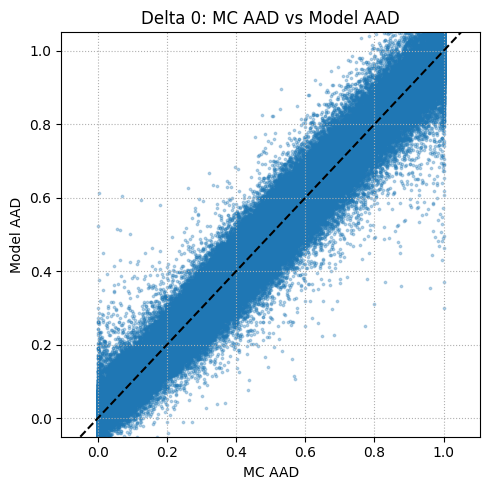

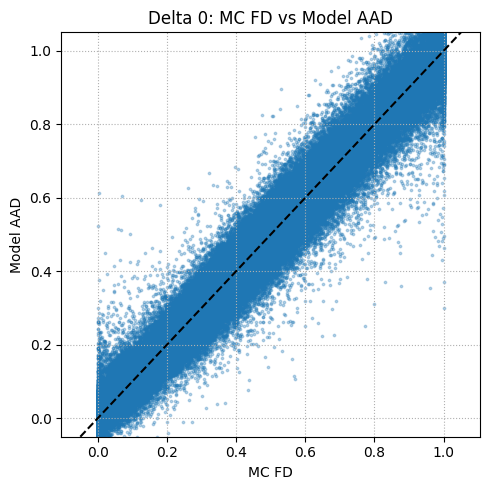

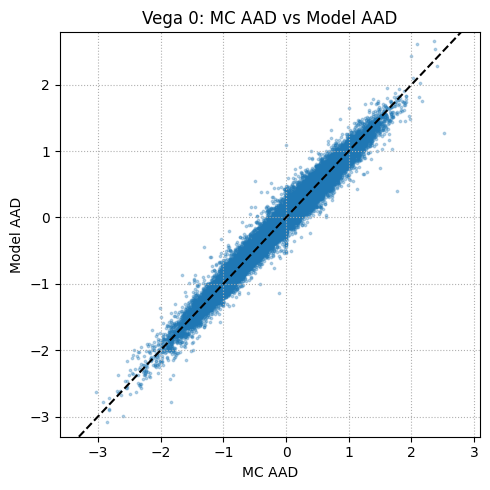

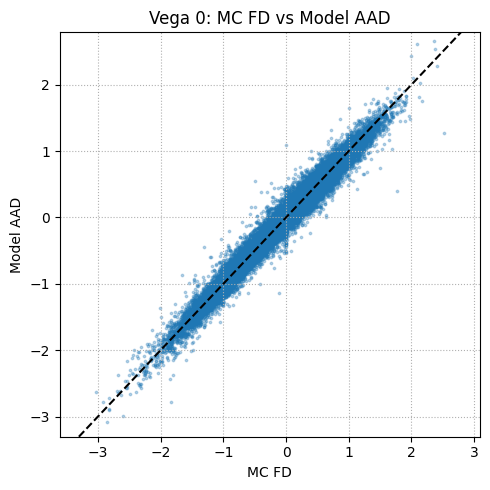

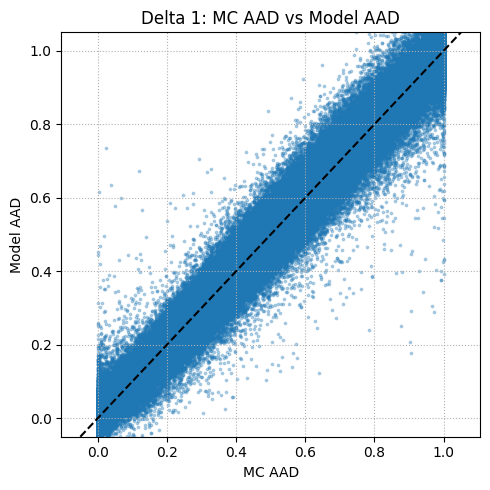

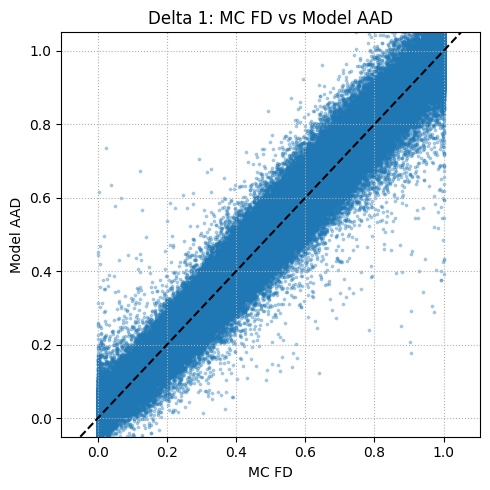

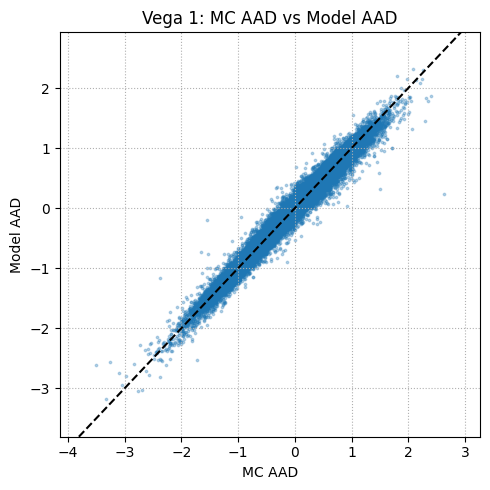

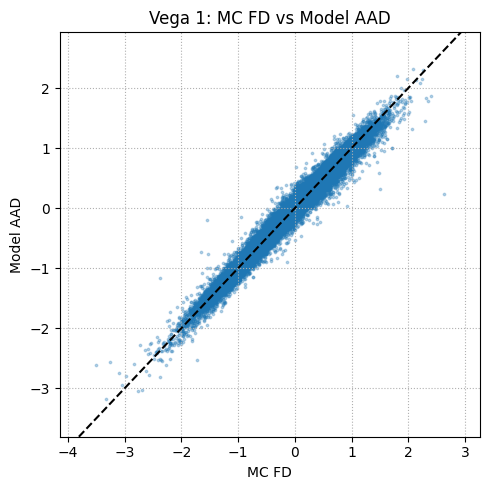

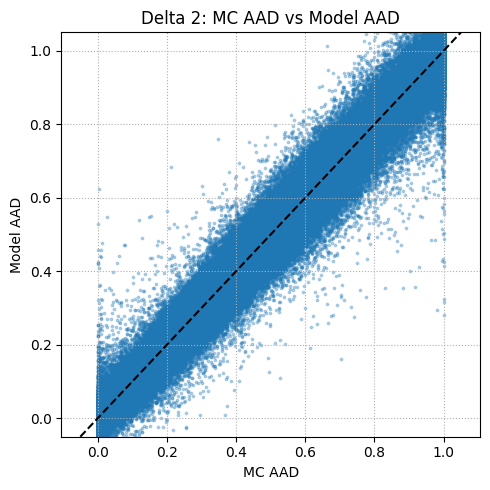

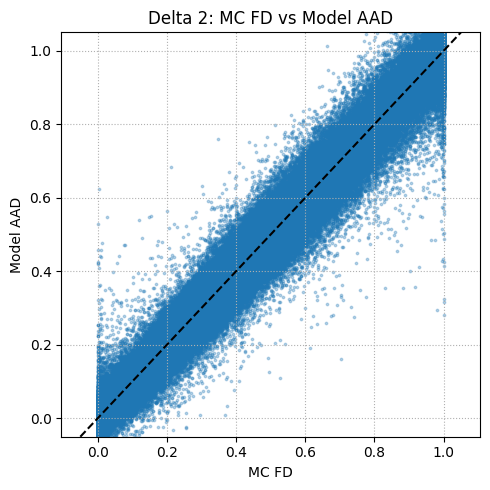

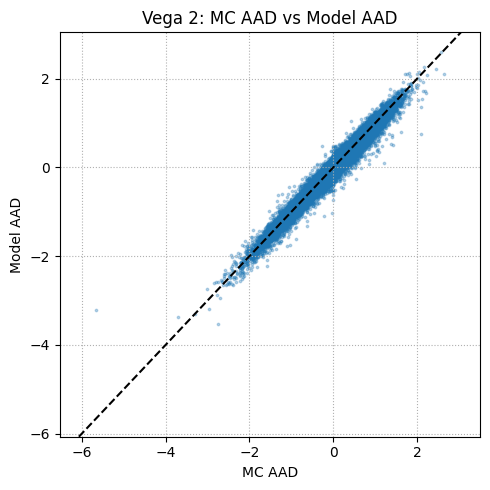

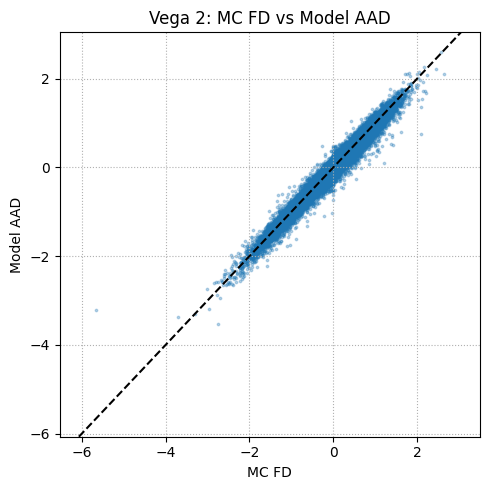

In [2]:
# Cell 2: Plot all 12 comparisons inline (no saving)

import pandas as pd
import matplotlib.pyplot as plt

# 1. Load saved files
aad_mc    = pd.read_parquet("Train_clean_5m_aad_greeks.parquet")
fd_mc     = pd.read_parquet("Train_clean_5m_fd_greeks.parquet")
model_aad = pd.read_parquet("Train_clean_5m_Model+AAD_greeks.parquet")

def plot_inline(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(5,5))
    plt.scatter(x, y, s=3, alpha=0.3)
    lo, hi = plt.xlim()
    plt.ylim(lo, hi)
    plt.plot([lo,hi], [lo,hi], 'k--')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(ls=":")
    plt.tight_layout()
    plt.show()

# 2. Loop through components
for i in range(3):
    plot_inline(
        aad_mc[f"delta_{i}"], model_aad[f"delta_{i}"],
        f"Delta {i}: MC AAD vs Model AAD", "MC AAD", "Model AAD"
    )
    plot_inline(
        fd_mc[f"delta_{i}"], model_aad[f"delta_{i}"],
        f"Delta {i}: MC FD vs Model AAD", "MC FD", "Model AAD"
    )
    plot_inline(
        aad_mc[f"vega_{i}"], model_aad[f"vega_{i}"],
        f"Vega {i}: MC AAD vs Model AAD", "MC AAD", "Model AAD"
    )
    plot_inline(
        fd_mc[f"vega_{i}"], model_aad[f"vega_{i}"],
        f"Vega {i}: MC FD vs Model AAD", "MC FD", "Model AAD"
    )


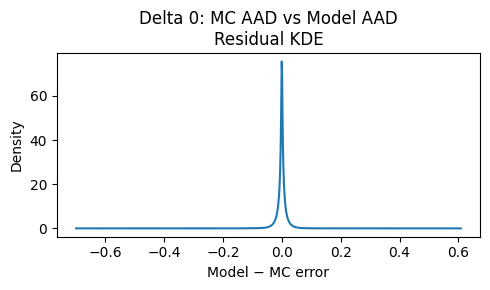

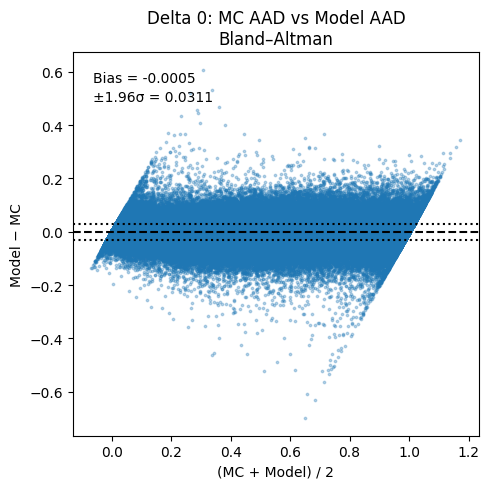

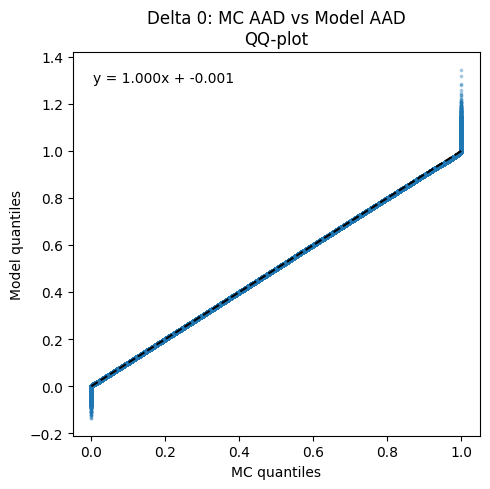

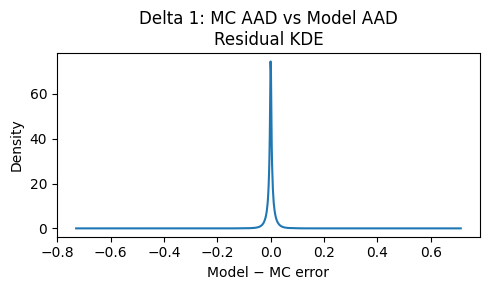

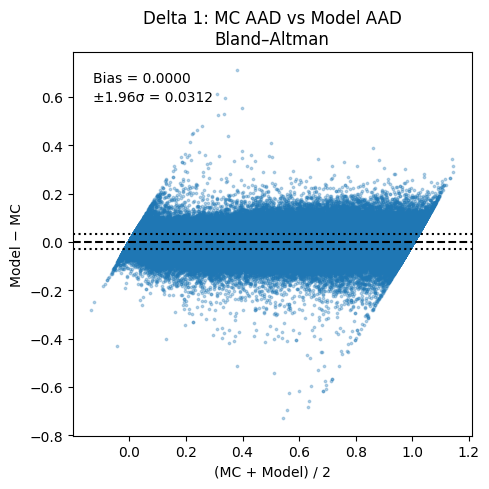

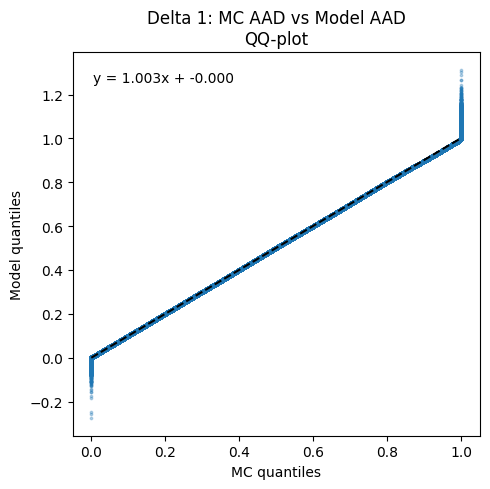

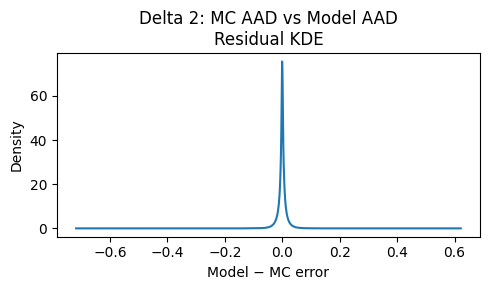

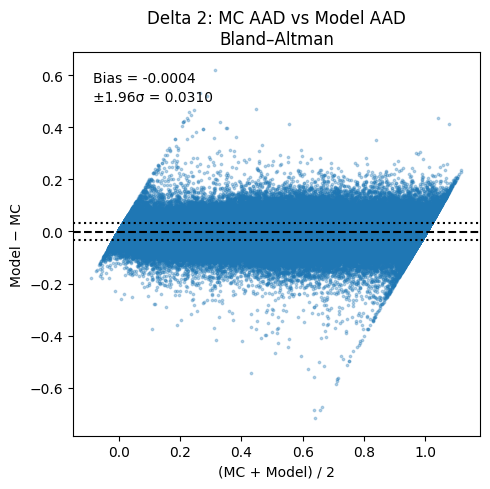

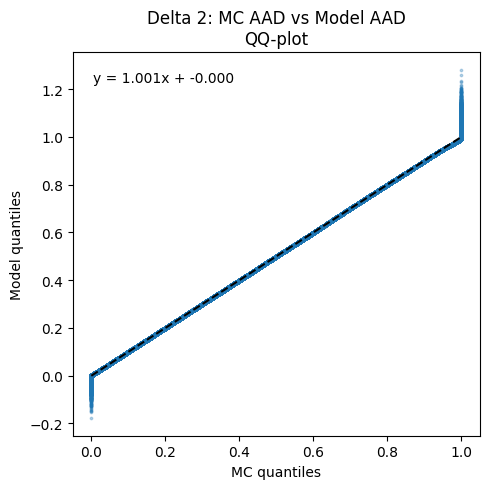

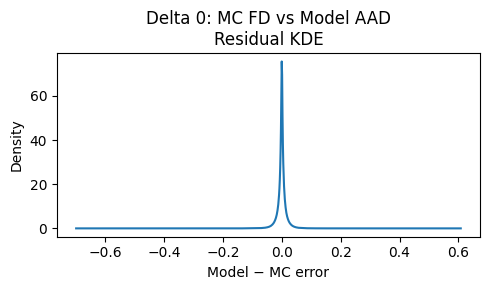

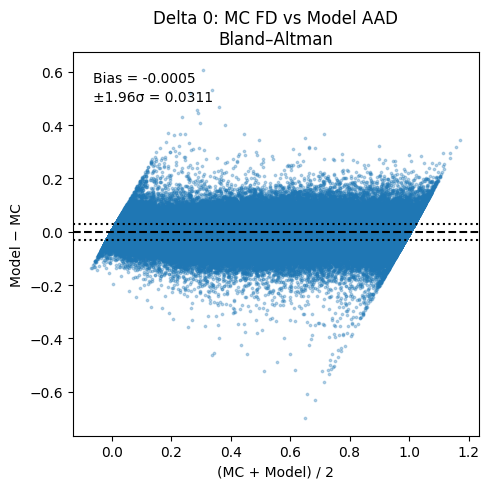

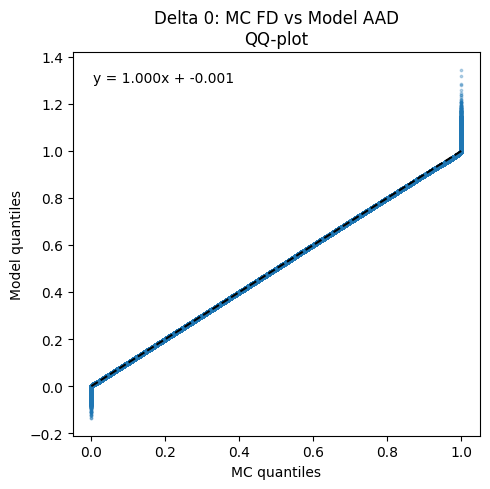

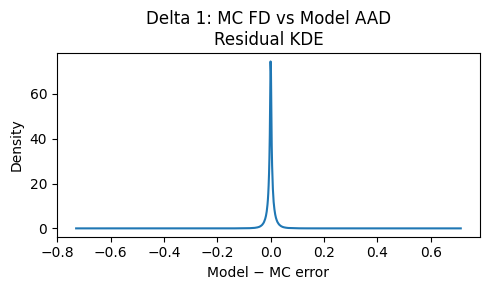

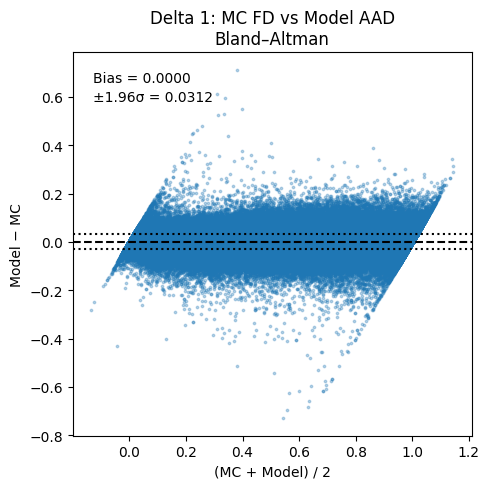

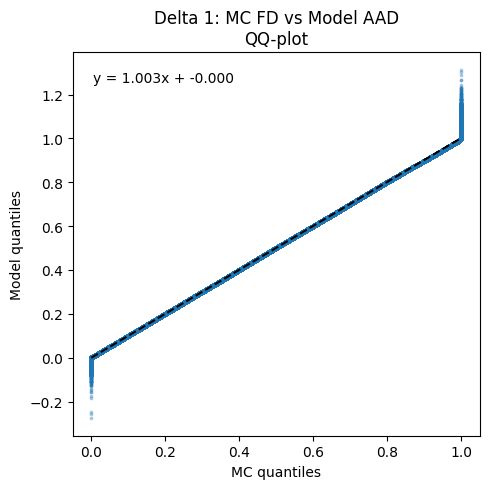

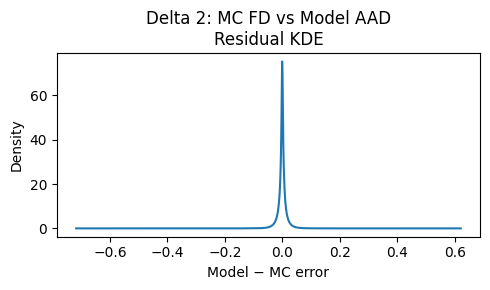

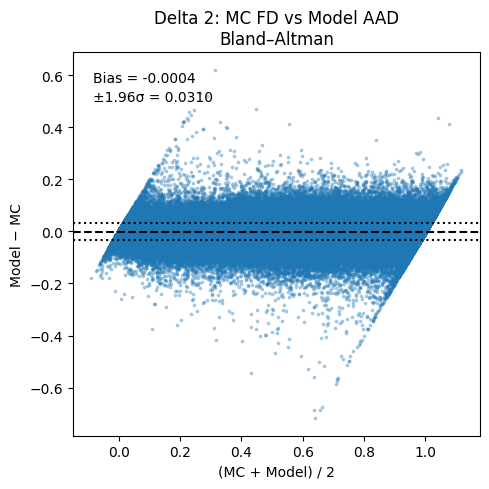

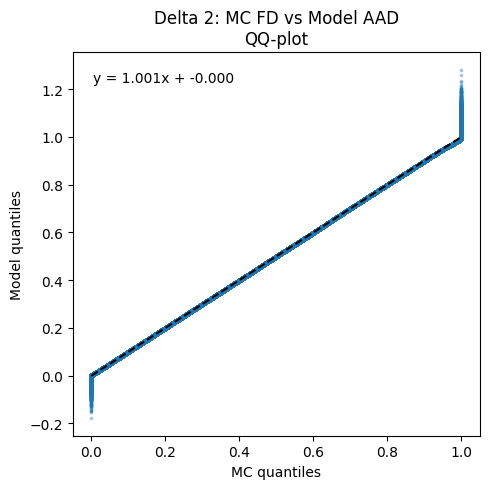

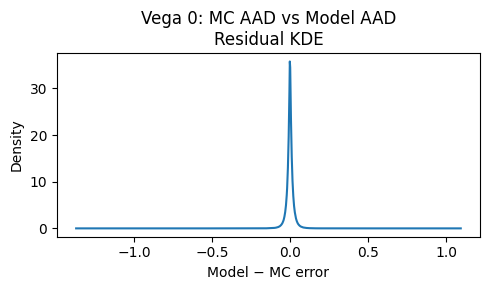

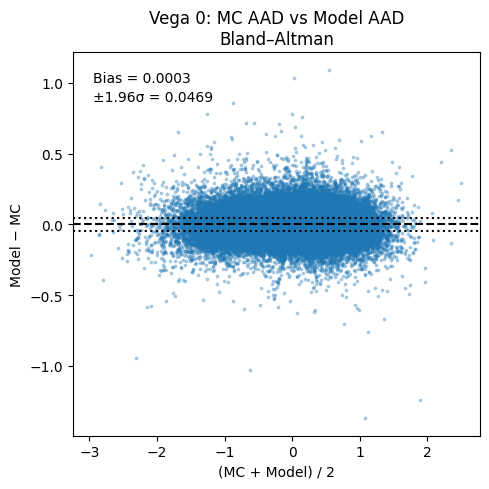

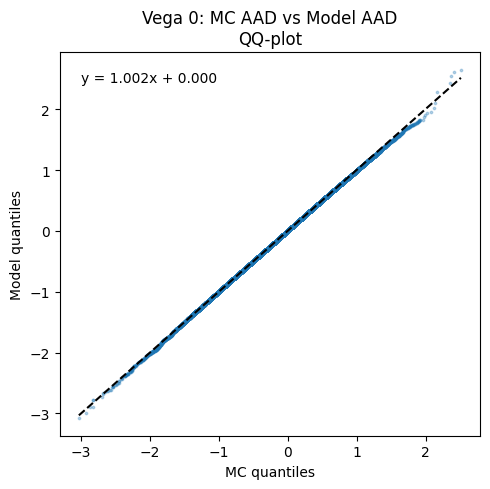

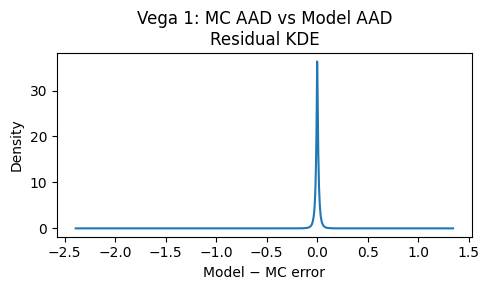

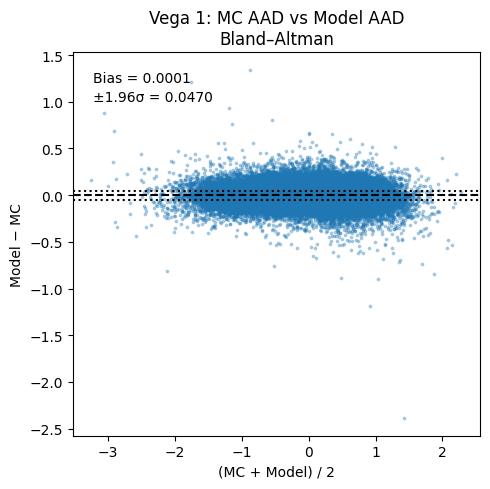

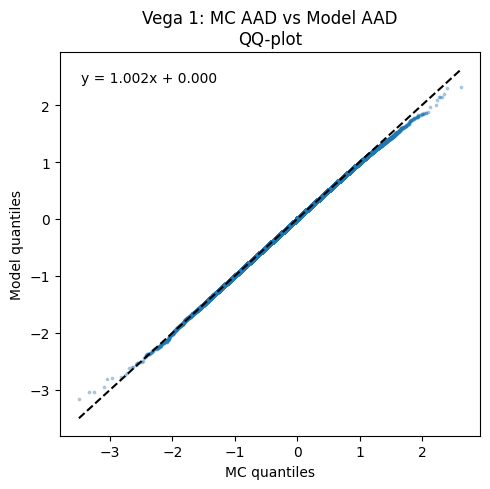

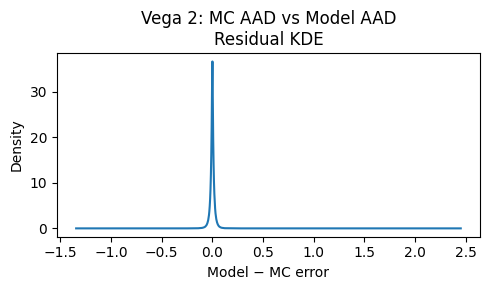

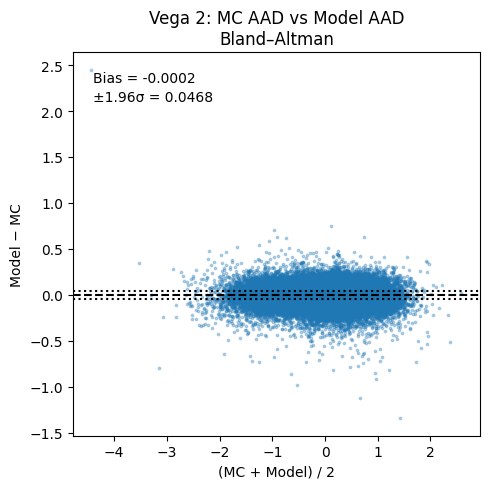

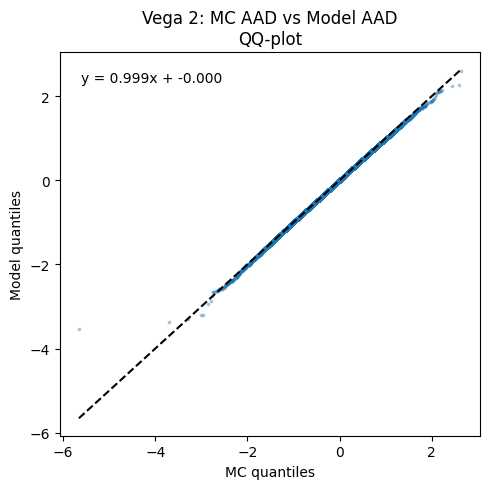

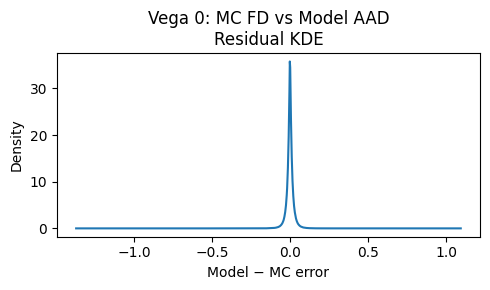

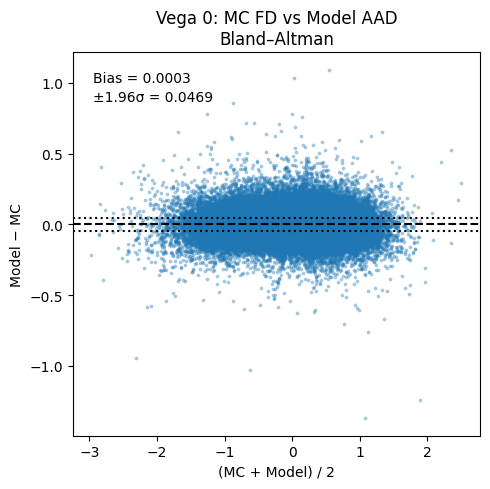

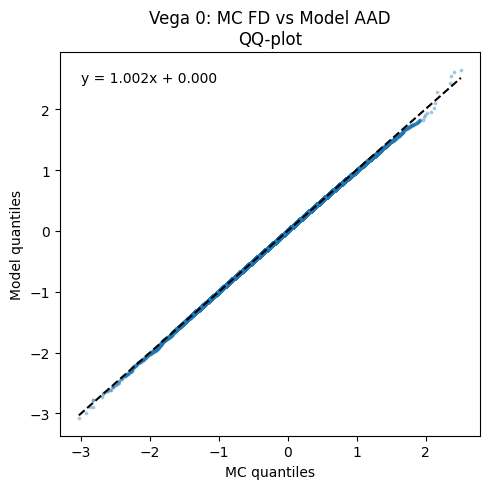

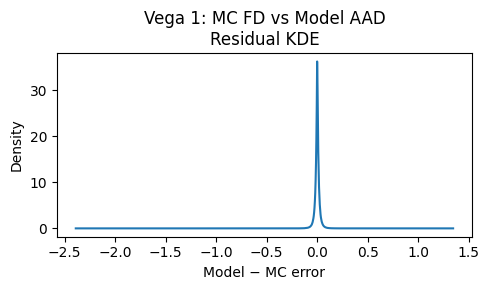

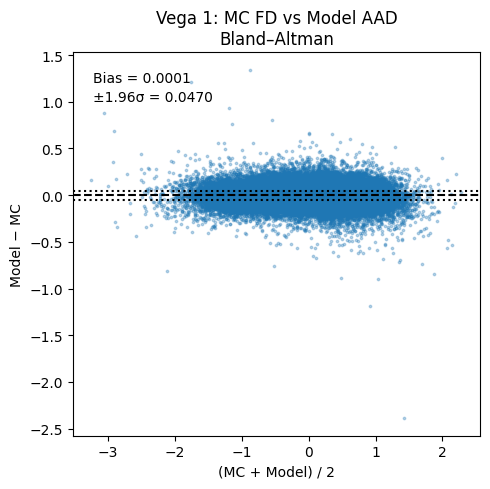

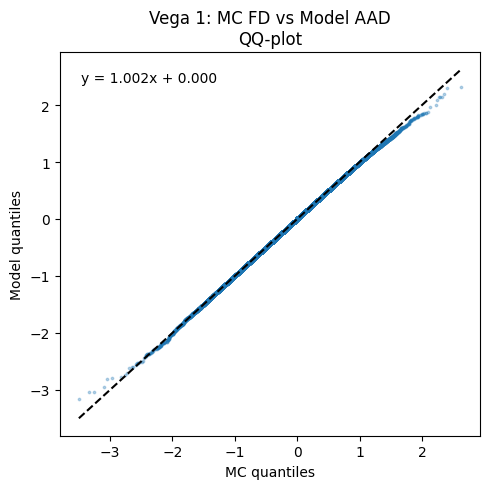

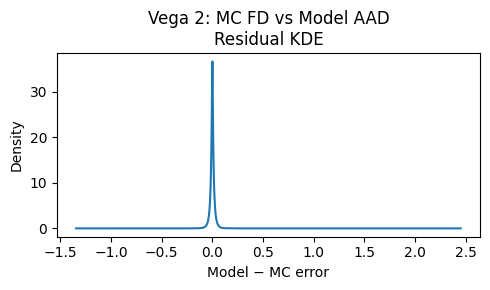

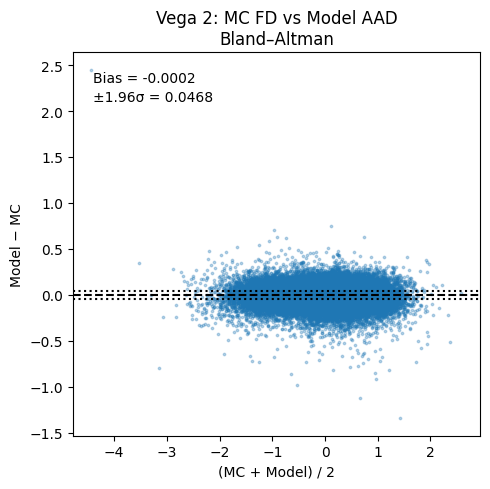

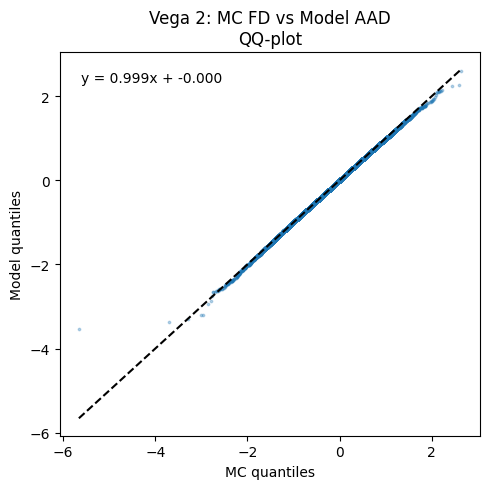

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# ——— 1. Load your data ———
aad_mc    = pd.read_parquet("Train_clean_5m_aad_greeks.parquet")
fd_mc     = pd.read_parquet("Train_clean_5m_fd_greeks.parquet")
model_aad = pd.read_parquet("Train_clean_5m_Model+AAD_greeks.parquet")

# ——— 2. Plotting functions ———
def plot_residual_kde(x, y, title):
    resid = y - x
    kde   = gaussian_kde(resid)
    xs    = np.linspace(resid.min(), resid.max(), 1000)
    plt.figure(figsize=(5,3))
    plt.plot(xs, kde(xs))
    plt.title(f"{title}\nResidual KDE")
    plt.xlabel("Model − MC error")
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

def plot_bland_altman(x, y, title):
    mean_vals = 0.5 * (x + y)
    diff      = y - x
    m, sd     = diff.mean(), diff.std()
    plt.figure(figsize=(5,5))
    plt.scatter(mean_vals, diff, s=3, alpha=0.3)
    plt.axhline(m,          linestyle='--', color='black')
    plt.axhline(m + 1.96*sd, linestyle=':',  color='black')
    plt.axhline(m - 1.96*sd, linestyle=':',  color='black')
    # annotate bias and limits in the corner instead of legend
    plt.text(0.05, 0.95, f"Bias = {m:.4f}",        transform=plt.gca().transAxes, va="top")
    plt.text(0.05, 0.90, f"±1.96σ = {1.96*sd:.4f}", transform=plt.gca().transAxes, va="top")
    plt.title(f"{title}\nBland–Altman")
    plt.xlabel("(MC + Model) / 2")
    plt.ylabel("Model − MC")
    plt.tight_layout()
    plt.show()

def plot_qq(x, y, title):
    sx, sy = np.sort(x), np.sort(y)
    plt.figure(figsize=(5,5))
    plt.scatter(sx, sy, s=3, alpha=0.3)
    m, b = np.polyfit(sx, sy, 1)
    plt.plot(sx, m*sx + b, 'k--')
    # annotate slope/intercept instead of legend
    plt.text(0.05, 0.95, f"y = {m:.3f}x + {b:.3f}", transform=plt.gca().transAxes, va="top")
    plt.title(f"{title}\nQQ-plot")
    plt.xlabel("MC quantiles")
    plt.ylabel("Model quantiles")
    plt.tight_layout()
    plt.show()

# ——— 3. Loop over everything ———
for name in ["delta", "vega"]:
    for method, source in [("MC AAD", aad_mc), ("MC FD", fd_mc)]:
        for i in range(3):
            x     = source[f"{name}_{i}"].values
            y     = model_aad[f"{name}_{i}"].values
            title = f"{name.capitalize()} {i}: {method} vs Model AAD"

            plot_residual_kde(x, y, title)
            plot_bland_altman(x, y, title)
            plot_qq(x, y, title)


In [2]:
import pandas as pd
import numpy as np

# ——— load as before ———
aad_mc    = pd.read_parquet("Train_clean_5m_aad_greeks.parquet")
fd_mc     = pd.read_parquet("Train_clean_5m_fd_greeks.parquet")
model_aad = pd.read_parquet("Train_clean_5m_Model+AAD_greeks.parquet")

delta_cols = [f"delta_{i}" for i in range(3)]
vega_cols  = [f"vega_{i}"  for i in range(3)]

def enhanced_stats(stored: pd.DataFrame, model: pd.DataFrame, cols):
    diffs     = model[cols] - stored[cols]
    abs_diffs = diffs.abs()
    sq_diffs  = diffs ** 2

    stats = pd.DataFrame(index=cols)
    stats['count']     = diffs.count().values
    stats['mean_diff'] = diffs.mean().values
    stats['std_diff']  = diffs.std().values
    stats['min_diff']  = diffs.min().values
    stats['25%']       = diffs.quantile(0.25).values
    stats['50%']       = diffs.median().values
    stats['75%']       = diffs.quantile(0.75).values
    stats['max_diff']  = diffs.max().values

    # additional error metrics
    stats['MAE']  = abs_diffs.mean().values
    stats['MSE']  = sq_diffs.mean().values
    stats['RMSE'] = np.sqrt(stats['MSE'])

    # R^2 = (Pearson r)^2
    r2_list = []
    for col in cols:
        r = stored[col].corr(model[col])
        r2_list.append(r**2)
    stats['R2'] = r2_list

    return stats

# compute
delta_aad_vs_mc_aad = enhanced_stats(aad_mc,    model_aad, delta_cols)
delta_aad_vs_mc_fd  = enhanced_stats(fd_mc,     model_aad, delta_cols)
vega_aad_vs_mc_aad  = enhanced_stats(aad_mc,    model_aad, vega_cols)
vega_aad_vs_mc_fd   = enhanced_stats(fd_mc,     model_aad, vega_cols)

# display
print("=== Delta: Model AAD vs MC AAD ===")
display(delta_aad_vs_mc_aad)

print("\n=== Delta: Model AAD vs MC FD ===")
display(delta_aad_vs_mc_fd)

print("\n=== Vega: Model AAD vs MC AAD ===")
display(vega_aad_vs_mc_aad)

print("\n=== Vega: Model AAD vs MC FD ===")
display(vega_aad_vs_mc_fd)


=== Delta: Model AAD vs MC AAD ===


,count,mean_diff,std_diff,min_diff,25%,50%,75%,max_diff,MAE,MSE,RMSE,R2
delta_0,4791421,-0.000471,0.015854,-0.699800,-0.005124,-0.000295,0.004262,0.608373,0.009048,0.000252,0.015861,0.993257
delta_1,4791421,0.000038,0.015929,-0.730030,-0.004699,-0.000051,0.004592,0.713059,0.009005,0.000254,0.015929,0.993301
delta_2,4791421,-0.000382,0.015792,-0.717513,-0.004916,-0.000197,0.004289,0.621425,0.008913,0.000250,0.015797,0.993394



=== Delta: Model AAD vs MC FD ===


,count,mean_diff,std_diff,min_diff,25%,50%,75%,max_diff,MAE,MSE,RMSE,R2
delta_0,4791421,-0.000471,0.015854,-0.699800,-0.005124,-0.000295,0.004262,0.608372,0.009048,0.000252,0.015861,0.993257
delta_1,4791421,0.000038,0.015929,-0.730023,-0.004699,-0.000051,0.004592,0.713058,0.009005,0.000254,0.015929,0.993301
delta_2,4791421,-0.000382,0.015792,-0.717513,-0.004916,-0.000197,0.004289,0.621366,0.008913,0.000250,0.015797,0.993394



=== Vega: Model AAD vs MC AAD ===


,count,mean_diff,std_diff,min_diff,25%,50%,75%,max_diff,MAE,MSE,RMSE,R2
vega_0,4791421,0.000323,0.023907,-1.369824,-0.008839,0.000174,0.009270,1.094311,0.014822,0.000572,0.023909,0.982463
vega_1,4791421,0.000134,0.023960,-2.389564,-0.008918,0.000099,0.009167,1.344957,0.014850,0.000574,0.023960,0.982731
vega_2,4791421,-0.000158,0.023866,-1.343818,-0.008930,0.000067,0.008954,2.451042,0.014765,0.000570,0.023867,0.982788



=== Vega: Model AAD vs MC FD ===


,count,mean_diff,std_diff,min_diff,25%,50%,75%,max_diff,MAE,MSE,RMSE,R2
vega_0,4791421,0.000323,0.023907,-1.369823,-0.008839,0.000174,0.009271,1.094311,0.014822,0.000572,0.023909,0.982463
vega_1,4791421,0.000134,0.023960,-2.389564,-0.008918,0.000099,0.009167,1.344949,0.014850,0.000574,0.023960,0.982731
vega_2,4791421,-0.000158,0.023866,-1.343816,-0.008930,0.000067,0.008954,2.451043,0.014765,0.000570,0.023867,0.982788
